In [ ]:
import pandas as pd
import numpy as np
from tsai.all import *
from fastai.metrics import rmse, mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch

from tsai.inference import load_learner

import seaborn as sns

from datasets import load_dataset

import optuna

import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def load_and_preprocess(file_path):
    """Data loading and preprocessing for stock data"""
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[["Date", "Price"]]
    df = df.set_index('Date')
    df["Price"] = df["Price"].str.replace(',', '').astype(float)
    return df

In [3]:
# Load DAX and SP500 data
dax_df = load_and_preprocess("data/DAX Historical Data.csv")
sp500_df = load_and_preprocess("data/S&P 500 Historical Data.csv")

# Load additional stock indices
bovespa_df = load_and_preprocess("data/Bovespa Historical Data.csv")
cac40_df = load_and_preprocess("data/CAC 40 Historical Data.csv")
dowjones_df = load_and_preprocess("data/Dow Jones Industrial Average Historical Data.csv")
ftse100_df = load_and_preprocess("data/FTSE 100 Historical Data.csv")
nikkei225_df = load_and_preprocess("data/Nikkei 225 Historical Data.csv")
tsx_df = load_and_preprocess("data/S&P_TSX Composite Historical Data.csv")

dax_df = dax_df.sort_index()
sp500_df = sp500_df.sort_index()
bovespa_df = bovespa_df.sort_index()
cac40_df = cac40_df.sort_index()
dowjones_df = dowjones_df.sort_index()
ftse100_df = ftse100_df.sort_index()
nikkei225_df = nikkei225_df.sort_index()
tsx_df = tsx_df.sort_index()

In [4]:
# Fill df with all time series
nn5 = pd.read_parquet("data/nn5_daily.parquet")
tourism = pd.read_parquet("data/tourism.parquet")

# Split into train and val
def split_df(df, domain):
    train_df = df.copy()
    val_df = df.copy()
    
    for index, row in df.iterrows():
        for col in df.columns:
            split_index = int(len(row[col]) * 0.8)
            train_df.at[index, col] = row[col][:split_index]
            val_df.at[index, col] = row[col][split_index:]
    
    train_df["domain"] = domain
    val_df["domain"] = domain
    return train_df, val_df

train_nn5, val_nn5 = split_df(nn5, "NN5")
train_tourism, val_tourism = split_df(tourism, "tourism")

combined_train_df = pd.concat([train_nn5, train_tourism], ignore_index=True)
combined_val_df = pd.concat([val_nn5, val_tourism], ignore_index=True)

In [5]:
dax_df_train_leak = dax_df[(dax_df.index.year > 2015) & (dax_df.index < "2020-07-01")]
dax_df_val_leak = dax_df[(dax_df.index >= "2020-07-01") & (dax_df.index.year < 2021)]

bovespa_train_leak = bovespa_df[(bovespa_df.index.year > 2015) & (bovespa_df.index < "2020-07-01")]
bovespa_val_leak = bovespa_df[(bovespa_df.index >= "2020-07-01") & (bovespa_df.index.year < 2021)]

cac40_train_leak = cac40_df[(cac40_df.index.year > 2015) & (cac40_df.index < "2020-07-01")]
cac40_val_leak = cac40_df[(cac40_df.index >= "2020-07-01") & (cac40_df.index.year < 2021)]

dowjones_train_leak = dowjones_df[(dowjones_df.index.year > 2015) & (dowjones_df.index < "2020-07-01")]
dowjones_val_leak = dowjones_df[(dowjones_df.index >= "2020-07-01") & (dowjones_df.index.year < 2021)]

ftse100_train_leak = ftse100_df[(ftse100_df.index.year > 2015) & (ftse100_df.index < "2020-07-01")]
ftse100_val_leak = ftse100_df[(ftse100_df.index >= "2020-07-01") & (ftse100_df.index.year < 2021)]

nikkei225_train_leak = nikkei225_df[(nikkei225_df.index.year > 2015) & (nikkei225_df.index < "2020-07-01")]
nikkei225_val_leak = nikkei225_df[(nikkei225_df.index >= "2020-07-01") & (nikkei225_df.index.year < 2021)]

tsx_train_leak = tsx_df[(tsx_df.index.year > 2015) & (tsx_df.index < "2020-07-01")]
tsx_val_leak = tsx_df[(tsx_df.index >= "2020-07-01") & (tsx_df.index.year < 2021)]

dax_df_train_no_leak = dax_df[dax_df.index < "2019-07-01"]
dax_df_val_no_leak = dax_df[(dax_df.index >= "2019-07-01") & (dax_df.index.year < 2020)]

bovespa_train_no_leak = bovespa_df[bovespa_df.index < "2019-07-01"]
bovespa_val_no_leak = bovespa_df[(bovespa_df.index >= "2019-07-01") & (bovespa_df.index.year < 2020)]

cac40_train_no_leak = cac40_df[cac40_df.index < "2019-07-01"]
cac40_val_no_leak = cac40_df[(cac40_df.index >= "2019-07-01") & (cac40_df.index.year < 2020)]

dowjones_train_no_leak = dowjones_df[dowjones_df.index < "2019-07-01"]
dowjones_val_no_leak = dowjones_df[(dowjones_df.index >= "2019-07-01") & (dowjones_df.index.year < 2020)]

ftse100_train_no_leak = ftse100_df[ftse100_df.index < "2019-07-01"]
ftse100_val_no_leak = ftse100_df[(ftse100_df.index >= "2019-07-01") & (ftse100_df.index.year < 2020)]

nikkei225_train_no_leak = nikkei225_df[nikkei225_df.index < "2019-07-01"]
nikkei225_val_no_leak = nikkei225_df[(nikkei225_df.index >= "2019-07-01") & (nikkei225_df.index.year < 2020)]

tsx_train_no_leak = tsx_df[tsx_df.index < "2019-07-01"]
tsx_val_no_leak = tsx_df[(tsx_df.index >= "2019-07-01") & (tsx_df.index.year < 2020)]

sp500_df_2015_to_2019 = sp500_df[sp500_df.index.year < 2020]
sp500_df_2020 = sp500_df[sp500_df.index.year == 2020]

In [6]:
sp500_df_2020

,Price
Date,
2020-01-02,3257.8
2020-01-03,3234.8
2020-01-06,3246.3
2020-01-07,3237.2
2020-01-08,3253.1
...,...
2020-12-24,3703.1
2020-12-28,3735.4
2020-12-29,3727.0


In [7]:
# Prepare leak dataframes
dax_domain_train_df_leak = pd.DataFrame({"values": [dax_df_train_leak["Price"].values], "domain": "DAX"})
dax_domain_val_df_leak = pd.DataFrame({"values": [dax_df_val_leak["Price"].values], "domain": "DAX"})

bovespa_domain_train_df_leak = pd.DataFrame({"values": [bovespa_train_leak["Price"].values], "domain": "Bovespa"})
bovespa_domain_val_df_leak = pd.DataFrame({"values": [bovespa_val_leak["Price"].values], "domain": "Bovespa"})
cac40_domain_train_df_leak = pd.DataFrame({"values": [cac40_train_leak["Price"].values], "domain": "CAC40"})
cac40_domain_val_df_leak = pd.DataFrame({"values": [cac40_val_leak["Price"].values], "domain": "CAC40"})

dowjones_domain_train_df_leak = pd.DataFrame({"values": [dowjones_train_leak["Price"].values], "domain": "Dow Jones"})
dowjones_domain_val_df_leak = pd.DataFrame({"values": [dowjones_val_leak["Price"].values], "domain": "Dow Jones"})

ftse100_domain_train_df_leak = pd.DataFrame({"values": [ftse100_train_leak["Price"].values], "domain": "FTSE 100"})
ftse100_domain_val_df_leak = pd.DataFrame({"values": [ftse100_val_leak["Price"].values], "domain": "FTSE 100"})

nikkei225_domain_train_df_leak = pd.DataFrame({"values": [nikkei225_train_leak["Price"].values], "domain": "Nikkei 225"})
nikkei225_domain_val_df_leak = pd.DataFrame({"values": [nikkei225_val_leak["Price"].values], "domain": "Nikkei 225"})
tsx_domain_train_df_leak = pd.DataFrame({"values": [tsx_train_leak["Price"].values], "domain": "TSX"})
tsx_domain_val_df_leak = pd.DataFrame({"values": [tsx_val_leak["Price"].values], "domain": "TSX"})

# Combine all training data leak
combined_train_leak_df = pd.concat([
    dax_domain_train_df_leak, 
    bovespa_domain_train_df_leak, 
    cac40_domain_train_df_leak,
    dowjones_domain_train_df_leak,
    ftse100_domain_train_df_leak,
    nikkei225_domain_train_df_leak,
    tsx_domain_train_df_leak,
    combined_train_df
], ignore_index=True)
combined_val_leak_df = pd.concat([
    dax_domain_val_df_leak, 
    bovespa_domain_val_df_leak, 
    cac40_domain_val_df_leak,
    dowjones_domain_val_df_leak,
    ftse100_domain_val_df_leak,
    nikkei225_domain_val_df_leak,
    tsx_domain_val_df_leak,
    combined_val_df
], ignore_index=True)

# Prepare no-leak dataframes
dax_domain_train_df_no_leak = pd.DataFrame({"values": [dax_df_train_no_leak["Price"].values], "domain": "DAX"})
dax_domain_val_df_no_leak = pd.DataFrame({"values": [dax_df_val_no_leak["Price"].values], "domain": "DAX"})

bovespa_domain_train_df_no_leak = pd.DataFrame({"values": [bovespa_train_no_leak["Price"].values], "domain": "Bovespa"})
bovespa_domain_val_df_no_leak = pd.DataFrame({"values": [bovespa_val_no_leak["Price"].values], "domain": "Bovespa"})
cac40_domain_train_df_no_leak = pd.DataFrame({"values": [cac40_train_no_leak["Price"].values], "domain": "CAC40"})
cac40_domain_val_df_no_leak = pd.DataFrame({"values": [cac40_val_no_leak["Price"].values], "domain": "CAC40"})
dowjones_domain_train_df_no_leak = pd.DataFrame({"values": [dowjones_train_no_leak["Price"].values], "domain": "Dow Jones"})
dowjones_domain_val_df_no_leak = pd.DataFrame({"values": [dowjones_val_no_leak["Price"].values], "domain": "Dow Jones"})
ftse100_domain_train_df_no_leak = pd.DataFrame({"values": [ftse100_train_no_leak["Price"].values], "domain": "FTSE 100"})
ftse100_domain_val_df_no_leak = pd.DataFrame({"values": [ftse100_val_no_leak["Price"].values], "domain": "FTSE 100"})
nikkei225_domain_train_df_no_leak = pd.DataFrame({"values": [nikkei225_train_no_leak["Price"].values], "domain": "Nikkei 225"})
nikkei225_domain_val_df_no_leak = pd.DataFrame({"values": [nikkei225_val_no_leak["Price"].values], "domain": "Nikkei 225"})
tsx_domain_train_df_no_leak = pd.DataFrame({"values": [tsx_train_no_leak["Price"].values], "domain": "TSX"})
tsx_domain_val_df_no_leak = pd.DataFrame({"values": [tsx_val_no_leak["Price"].values], "domain": "TSX"})
# Combine all training data no leak
combined_train_no_leak_df = pd.concat([
    dax_domain_train_df_no_leak, 
    bovespa_domain_train_df_no_leak, 
    cac40_domain_train_df_no_leak,
    dowjones_domain_train_df_no_leak,
    ftse100_domain_train_df_no_leak,
    nikkei225_domain_train_df_no_leak,
    tsx_domain_train_df_no_leak,
    combined_train_df
], ignore_index=True)
combined_val_no_leak_df = pd.concat([
    dax_domain_val_df_no_leak, 
    bovespa_domain_val_df_no_leak, 
    cac40_domain_val_df_no_leak,
    dowjones_domain_val_df_no_leak,
    ftse100_domain_val_df_no_leak,
    nikkei225_domain_val_df_no_leak,
    tsx_domain_val_df_no_leak,
    combined_val_df
], ignore_index=True)

In [8]:
# Time series and observations info
df = combined_train_leak_df
for df in [combined_train_no_leak_df, combined_val_no_leak_df, combined_train_leak_df, combined_val_leak_df]:
    print(len(df))
    time_points = 0
    for i in range(len(df)):
        time_points += len(df["values"][i])

    print(time_points)

print("---")

# 

484
165366
484
40488
484
165369
484
40490
---


In [9]:
# Time series and observations info
df = combined_train_leak_df
for df in [combined_train_no_leak_df, combined_val_no_leak_df, combined_train_leak_df, combined_val_leak_df]:
    print(len(df))
    time_points = 0
    for i in range(len(df)):
        time_points += len(df["values"][i])

    print(time_points)

484
165366
484
40488
484
165369
484
40490


In [10]:
# Get all stock index values between 2020-01-31 and 2020-12-28
sp500_df_test = sp500_df[(sp500_df.index >= "2020-01-31") & (sp500_df.index <= "2020-12-28")]
dax_df_test = dax_df[(dax_df.index >= "2020-01-31") & (dax_df.index <= "2020-12-28")]
bovespa_df_test = bovespa_df[(bovespa_df.index >= "2020-01-31") & (bovespa_df.index <= "2020-12-28")]
cac40_df_test = cac40_df[(cac40_df.index >= "2020-01-31") & (cac40_df.index <= "2020-12-28")]
dowjones_df_test = dowjones_df[(dowjones_df.index >= "2020-01-31") & (dowjones_df.index <= "2020-12-28")]
ftse100_df_test = ftse100_df[(ftse100_df.index >= "2020-01-31") & (ftse100_df.index <= "2020-12-28")]
nikkei225_df_test = nikkei225_df[(nikkei225_df.index >= "2020-01-31") & (nikkei225_df.index <= "2020-12-28")]
tsx_df_test = tsx_df[(tsx_df.index >= "2020-01-31") & (tsx_df.index <= "2020-12-28")]

In [11]:
# Number of leakage observations
print(len(dax_df_test))
print(len(bovespa_df_test))
print(len(cac40_df_test))
print(len(dowjones_df_test))
print(len(ftse100_df_test))
print(len(nikkei225_df_test))
print(len(tsx_df_test))
print("---")
print(len(dax_df_test) + len(bovespa_df_test) + len(cac40_df_test) + len(dowjones_df_test) + len(ftse100_df_test) + len(nikkei225_df_test) + len(tsx_df_test))

231
226
233
230
230
222
228
---
1600


In [12]:
def scale_by_domain(train_df, val_df):
    """
    Scale values by domain using separate scalers.
    Returns scaled dataframes and dict of scalers
    """
    scalers = {}
    train_df_scaled = train_df.copy()
    val_df_scaled = val_df.copy()
    
    # Get unique domains
    unique_domains = train_df['domain'].unique()
    
    for domain in unique_domains:
        # Create scaler for this domain
        scaler = MinMaxScaler()
        
        # Get indices for this domain
        train_domain_idx = train_df['domain'] == domain
        val_domain_idx = val_df['domain'] == domain
        
        # Get train values for this domain and flatten for scaling
        train_values = np.concatenate(train_df.loc[train_domain_idx, 'values'].values)
        
        # Fit scaler on train data
        scaler.fit(train_values.reshape(-1, 1))
        
        # Scale train values
        train_scaled = []
        for series in train_df.loc[train_domain_idx, 'values']:
            scaled_series = scaler.transform(series.reshape(-1, 1)).flatten()
            train_scaled.append(scaled_series)
        
        # Scale validation values
        val_scaled = []
        for series in val_df.loc[val_domain_idx, 'values']:
            scaled_series = scaler.transform(series.reshape(-1, 1)).flatten()
            val_scaled.append(scaled_series)
        
        # Update scaled dataframes
        train_df_scaled.loc[train_domain_idx, 'values'] = train_scaled
        val_df_scaled.loc[val_domain_idx, 'values'] = val_scaled
        
        # Store scaler
        scalers[domain] = scaler
    
    return train_df_scaled, val_df_scaled, scalers

In [13]:
seq_len = 20
horizon = 10

# Scale data
train_df_scaled_leak, val_df_scaled_leak, scalers_leak = scale_by_domain(combined_train_leak_df, combined_val_leak_df)
train_df_scaled_no_leak, val_df_scaled_no_leak, scalers_no_leak = scale_by_domain(combined_train_no_leak_df, combined_val_no_leak_df)

In [14]:
scaler_sp500 = MinMaxScaler()
scaler_sp500.fit(sp500_df_2015_to_2019["Price"].values.reshape(-1, 1))

sp500_scaled = scaler_sp500.transform(sp500_df_2020["Price"].values.reshape(-1, 1))

In [15]:
# Create sequences for final test
X_test = []
y_test = []
    
sp500_scaled_flatten = sp500_scaled.flatten()

for i in range(0, len(sp500_scaled_flatten) - seq_len - horizon + 1, horizon):
    X_seq = sp500_scaled_flatten[i:(i + seq_len)]
    y_seq = sp500_scaled_flatten[(i + seq_len):(i + seq_len + horizon)]
    X_test.append(X_seq)
    y_test.append(y_seq)
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [16]:
sp500_dates = sp500_df_2020.index.tolist()

test_dates = []
for i in range(0, len(sp500_scaled_flatten) - seq_len - horizon + 1, horizon):
    # For each sequence, we predict horizon values starting at i + seq_len
    for j in range(horizon):
        if i + seq_len + j < len(sp500_dates):
            test_dates.append(sp500_dates[i + seq_len + j])

# Find date corresponding to 63rd point for vertical line, i.e. the start of May
split_point = 63
split_date = test_dates[split_point] if split_point < len(test_dates) else test_dates[-1]

# Store MAE values for averaging
all_mae_no_leak_first = []
all_mae_leak_first = []
all_mae_no_leak_after = []
all_mae_leak_after = []

# Store predictions for combined plot
all_preds_no_leak = []
all_preds_leak = []
target_rescaled_stored = None

for seed in [410, 1425, 1680, 1825, 2287, 3658, 4013, 4507, 8936, 9675]:
    fcst_no_leak = load_learner(f"models/fcst_no_leak_seed_{seed}.pkl")
    fcst_leak = load_learner(f"models/fcst_leak_seed_{seed}.pkl")

    X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    raw_preds_leak, target_leak, preds_leak = fcst_leak.get_X_preds(X_test_reshaped, y_test)
    raw_preds_no_leak, target_no_leak, preds_no_leak = fcst_no_leak.get_X_preds(X_test_reshaped, y_test)

    targets_flat_no_leak = target_no_leak.flatten()
    raw_preds_flat_no_leak = raw_preds_no_leak.flatten()

    targets_flat_leak = target_leak.flatten()
    raw_preds_flat_leak = raw_preds_leak.flatten()

    # Rescale to have correct plot
    target_no_leak_rescaled = torch.Tensor(scaler_sp500.inverse_transform(targets_flat_no_leak.reshape(-1, 1))).flatten()
    preds_no_leak_rescaled = torch.Tensor(scaler_sp500.inverse_transform(raw_preds_flat_no_leak.reshape(-1, 1))).flatten()

    target_leak_rescaled = torch.Tensor(scaler_sp500.inverse_transform(targets_flat_leak.reshape(-1, 1))).flatten()
    preds_leak_rescaled = torch.Tensor(scaler_sp500.inverse_transform(raw_preds_flat_leak.reshape(-1, 1))).flatten()

    # Store predictions for combined plot
    all_preds_no_leak.append(preds_no_leak_rescaled.numpy())
    all_preds_leak.append(preds_leak_rescaled.numpy())
    if target_rescaled_stored is None:
        target_rescaled_stored = target_no_leak_rescaled.numpy()

    # Use dates for x-axis
    plot_dates = test_dates[:len(target_no_leak_rescaled)]
    
    # Filter to only show data until start of July 2020
    july_mask = [d.month < 7 for d in plot_dates]
    july_end_idx = sum(july_mask)
    
    # Calculate MAE for first 63 points and after split
    mae_no_leak_first63 = float(mae(target_no_leak_rescaled[:split_point], preds_no_leak_rescaled[:split_point]).item())
    mae_leak_first63 = float(mae(target_leak_rescaled[:split_point], preds_leak_rescaled[:split_point]).item())
    
    mae_no_leak_after = float(mae(target_no_leak_rescaled[split_point:july_end_idx], preds_no_leak_rescaled[split_point:july_end_idx]).item())
    mae_leak_after = float(mae(target_leak_rescaled[split_point:july_end_idx], preds_leak_rescaled[split_point:july_end_idx]).item())
    
    # Store for averaging
    all_mae_no_leak_first.append(mae_no_leak_first63)
    all_mae_leak_first.append(mae_leak_first63)
    all_mae_no_leak_after.append(mae_no_leak_after)
    all_mae_leak_after.append(mae_leak_after)
    
    # Get y range for annotation positioning
    y_max = max(target_no_leak_rescaled.max().item(), preds_no_leak_rescaled.max().item(), preds_leak_rescaled.max().item())
    y_min = min(target_no_leak_rescaled.min().item(), preds_no_leak_rescaled.min().item(), preds_leak_rescaled.min().item())
    y_range = y_max - y_min
    
    # Create plotly figure
    fig = go.Figure()
    
    # Add traces with dates on x-axis
    fig.add_trace(go.Scatter(
        x=plot_dates,
        y=target_no_leak_rescaled.numpy(),
        mode='lines',
        name='True Values',
        line=dict(color='blue', width=2)
    ))
    
    fig.add_trace(go.Scatter(
        x=plot_dates,
        y=preds_no_leak_rescaled.numpy(),
        mode='lines',
        name='Predictions No Leak',
        line=dict(color='green', width=1.5),
        opacity=0.7
    ))
    
    fig.add_trace(go.Scatter(
        x=plot_dates,
        y=preds_leak_rescaled.numpy(),
        mode='lines',
        name='Predictions Leak',
        line=dict(color='red', width=1.5),
        opacity=0.7
    ))
    
    # Add vertical dotted line at 63rd point
    fig.add_shape(
        type="line",
        x0=split_date,
        x1=split_date,
        y0=y_min - 0.05 * y_range,
        y1=y_max + 0.05 * y_range,
        line=dict(color='gray', width=2, dash='dot')
    )
    
    # Add annotation for the vertical line
    fig.add_annotation(
        x=split_date,
        y=y_max + 0.05 * y_range,
        text=split_date.strftime("%Y-%m-%d"),
        showarrow=False,
        font=dict(size=10),
        yanchor="bottom"
    )
    
    # Left side, MAE for first 63 points
    left_date = plot_dates[int(split_point * 0.3)]
    fig.add_annotation(
        x=left_date,
        y=y_min - 0.02 * y_range,
        text=f"<b>MAE (Start to {split_date.strftime('%m/%d')})</b><br>No Leak: {mae_no_leak_first63:.2f}<br>Leak: {mae_leak_first63:.2f}",
        showarrow=False,
        font=dict(size=11),
        align='left',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1,
        yanchor="top"
    )
    
    # Right side, MAE for after split (through June only)
    right_idx = split_point + int((july_end_idx - split_point) * 0.5)
    right_date = plot_dates[right_idx] if right_idx < len(plot_dates) else plot_dates[-1]
    fig.add_annotation(
        x=right_date,
        y=y_min - 0.02 * y_range,
        text=f"<b>MAE ({split_date.strftime('%m/%d')} to June)</b><br>No Leak: {mae_no_leak_after:.2f}<br>Leak: {mae_leak_after:.2f}",
        showarrow=False,
        font=dict(size=11),
        align='left',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1,
        yanchor="top"
    )
    
    fig.update_layout(
        title=f"S&P 500 Forecasting Results With Seed {seed}",
        xaxis_title="Date",
        yaxis_title="Price",
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        width=1000,
        height=550,
        xaxis=dict(tickformat="%b %Y"),
        margin=dict(b=100)
    )
    
    fig.show()
    fig.write_image(f"plots/sp500_forecasting_{seed}.png", scale=2)


In [17]:
avg_mae_no_leak_first = np.mean(all_mae_no_leak_first)
avg_mae_leak_first = np.mean(all_mae_leak_first)
avg_mae_no_leak_after = np.mean(all_mae_no_leak_after)
avg_mae_leak_after = np.mean(all_mae_leak_after)

std_mae_no_leak_first = np.std(all_mae_no_leak_first)
std_mae_leak_first = np.std(all_mae_leak_first)
std_mae_no_leak_after = np.std(all_mae_no_leak_after)
std_mae_leak_after = np.std(all_mae_leak_after)

print(f"\nMAE (Start to {split_date.strftime('%Y-%m-%d')}):")
print(f"  No Leak: {avg_mae_no_leak_first:.4f} ± {std_mae_no_leak_first:.4f}")
print(f"  Leak:    {avg_mae_leak_first:.4f} ± {std_mae_leak_first:.4f}")

print(f"\nMAE (After {split_date.strftime('%Y-%m-%d')}):")
print(f"  No Leak: {avg_mae_no_leak_after:.4f} ± {std_mae_no_leak_after:.4f}")
print(f"  Leak:    {avg_mae_leak_after:.4f} ± {std_mae_leak_after:.4f}")


MAE (Start to 2020-05-01):
  No Leak: 216.8811 ± 17.1513
  Leak:    190.1536 ± 21.8846

MAE (After 2020-05-01):
  No Leak: 108.2739 ± 21.0973
  Leak:    108.6693 ± 38.8345


In [18]:
# Summary statistics across all seeds
seeds = [410, 1425, 1680, 1825, 2287, 3658, 4013, 4507, 8936, 9675]
n_seeds = len(seeds)

# Compare MAE across seeds - before split
leak_better_before = sum(1 for leak, no_leak in zip(all_mae_leak_first, all_mae_no_leak_first) if leak < no_leak)
leak_worse_before = sum(1 for leak, no_leak in zip(all_mae_leak_first, all_mae_no_leak_first) if leak > no_leak)

# Compare MAE across seeds - after split
leak_better_after = sum(1 for leak, no_leak in zip(all_mae_leak_after, all_mae_no_leak_after) if leak < no_leak)
leak_worse_after = sum(1 for leak, no_leak in zip(all_mae_leak_after, all_mae_no_leak_after) if leak > no_leak)

# Combined plot with mean and std bands
all_preds_no_leak_arr = np.array(all_preds_no_leak)
all_preds_leak_arr = np.array(all_preds_leak)

mean_preds_no_leak = np.mean(all_preds_no_leak_arr, axis=0)
std_preds_no_leak = np.std(all_preds_no_leak_arr, axis=0)
mean_preds_leak = np.mean(all_preds_leak_arr, axis=0)
std_preds_leak = np.std(all_preds_leak_arr, axis=0)

plot_dates = test_dates[:len(target_rescaled_stored)]

# Filter to only show data until start of July 2020
july_mask = [d.month < 7 for d in plot_dates]
july_end_idx = sum(july_mask)

plot_dates_july = plot_dates[:july_end_idx]
target_rescaled_july = target_rescaled_stored[:july_end_idx]
mean_preds_no_leak_july = mean_preds_no_leak[:july_end_idx]
std_preds_no_leak_july = std_preds_no_leak[:july_end_idx]
mean_preds_leak_july = mean_preds_leak[:july_end_idx]
std_preds_leak_july = std_preds_leak[:july_end_idx]

fig = go.Figure()

# True values
fig.add_trace(go.Scatter(
    x=plot_dates_july,
    y=target_rescaled_july,
    mode='lines',
    name='True Values',
    line=dict(color='blue', width=2.5)
))

# No Leak - mean with confidence band
fig.add_trace(go.Scatter(
    x=plot_dates_july + plot_dates_july[::-1],
    y=np.concatenate([mean_preds_no_leak_july + std_preds_no_leak_july, (mean_preds_no_leak_july - std_preds_no_leak_july)[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 255, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='No Leak +/- std'
))
fig.add_trace(go.Scatter(
    x=plot_dates_july,
    y=mean_preds_no_leak_july,
    mode='lines',
    name='No Leak (mean +/- std)',
    line=dict(color='green', width=2)
))

# Leak - mean with confidence band
fig.add_trace(go.Scatter(
    x=plot_dates_july + plot_dates_july[::-1],
    y=np.concatenate([mean_preds_leak_july + std_preds_leak_july, (mean_preds_leak_july - std_preds_leak_july)[::-1]]),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Leak +/- std'
))
fig.add_trace(go.Scatter(
    x=plot_dates_july,
    y=mean_preds_leak_july,
    mode='lines',
    name='Leak (mean +/- std)',
    line=dict(color='red', width=2)
))

# Vertical line at split
y_max = max(target_rescaled_july.max(), mean_preds_no_leak_july.max() + std_preds_no_leak_july.max(), mean_preds_leak_july.max() + std_preds_leak_july.max())
y_min = min(target_rescaled_july.min(), mean_preds_no_leak_july.min() - std_preds_no_leak_july.max(), mean_preds_leak_july.min() - std_preds_leak_july.max())
y_range = y_max - y_min

fig.add_shape(
    type="line",
    x0=split_date,
    x1=split_date,
    y0=y_min - 0.05 * y_range,
    y1=y_max + 0.05 * y_range,
    line=dict(color='gray', width=2, dash='dot')
)

# Annotations
fig.add_annotation(
    x=split_date,
    y=y_max + 0.08 * y_range,
    text=f"<b>{split_date.strftime('%Y-%m-%d')}</b>",
    showarrow=False,
    font=dict(size=11)
)

# Summary annotations
left_date = plot_dates_july[int(split_point * 0.3)]
fig.add_annotation(
    x=left_date,
    y=y_min - 0.02 * y_range,
    text=f"<b>During Covid Shock (n={n_seeds} seeds)</b><br>Leak better: {leak_better_before}/{n_seeds}<br>MAE No Leak: {avg_mae_no_leak_first:.1f}+/-{std_mae_no_leak_first:.1f}<br>MAE Leak: {avg_mae_leak_first:.1f}+/-{std_mae_leak_first:.1f}",
    showarrow=False,
    font=dict(size=10),
    align='left',
    bgcolor='rgba(255,255,255,0.9)',
    bordercolor='gray',
    borderwidth=1,
    yanchor="top"
)

right_idx = split_point + int((july_end_idx - split_point) * 0.5)
right_date = plot_dates_july[right_idx] if right_idx < len(plot_dates_july) else plot_dates_july[-1]
fig.add_annotation(
    x=right_date,
    y=y_min - 0.02 * y_range,
    text=f"<b>After Covid Shock (n={n_seeds} seeds)</b><br>Leak better: {leak_better_after}/{n_seeds}<br>MAE No Leak: {avg_mae_no_leak_after:.1f}+/-{std_mae_no_leak_after:.1f}<br>MAE Leak: {avg_mae_leak_after:.1f}+/-{std_mae_leak_after:.1f}",
    showarrow=False,
    font=dict(size=10),
    align='left',
    bgcolor='rgba(255,255,255,0.9)',
    bordercolor='gray',
    borderwidth=1,
    yanchor="top"
)

fig.update_layout(
    title=f"S&P 500 Forecasting: Combined Results Across {n_seeds} Seeds (Mean +/- Std)",
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        x=0.99, 
        y=0.99, 
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    width=1100,
    height=600,
    xaxis=dict(
        tickformat="%b %Y",
        dtick="M1",
        tickmode='auto',
        nticks=7
    ),
    margin=dict(b=120)
)

fig.show()
fig.write_image("plots/sp500_forecasting_combined_all_seeds.png", scale=2)


In [19]:
for i, seed in enumerate(seeds):
    # Calculate percentage differences (positive means leak is better)
    pct_diff_before = ((all_mae_no_leak_first[i] - all_mae_leak_first[i]) / all_mae_no_leak_first[i]) * 100
    pct_diff_after = ((all_mae_no_leak_after[i] - all_mae_leak_after[i]) / all_mae_no_leak_after[i]) * 100
    
# Calculate average percentage differences
avg_pct_diff_before = np.mean([((no_leak - leak) / no_leak) * 100 for no_leak, leak in zip(all_mae_no_leak_first, all_mae_leak_first)])
avg_pct_diff_after = np.mean([((no_leak - leak) / no_leak) * 100 for no_leak, leak in zip(all_mae_no_leak_after, all_mae_leak_after)])

table_data = []
for i, seed in enumerate(seeds):
    pct_diff_before = ((all_mae_no_leak_first[i] - all_mae_leak_first[i]) / all_mae_no_leak_first[i]) * 100
    pct_diff_after = ((all_mae_no_leak_after[i] - all_mae_leak_after[i]) / all_mae_no_leak_after[i]) * 100
    
    table_data.append({
        'Seed': seed,
        'No Leak (Before)': f"{all_mae_no_leak_first[i]:.2f}",
        'Leak (Before)': f"{all_mae_leak_first[i]:.2f}",
        '% Diff (Before)': f"{pct_diff_before:.2f}%",
        'No Leak (After)': f"{all_mae_no_leak_after[i]:.2f}",
        'Leak (After)': f"{all_mae_leak_after[i]:.2f}",
        '% Diff (After)': f"{pct_diff_after:.2f}%"
    })

# Add mean row
table_data.append({
    'Seed': 'Mean',
    'No Leak (Before)': f"{avg_mae_no_leak_first:.2f}",
    'Leak (Before)': f"{avg_mae_leak_first:.2f}",
    '% Diff (Before)': f"{avg_pct_diff_before:.2f}%",
    'No Leak (After)': f"{avg_mae_no_leak_after:.2f}",
    'Leak (After)': f"{avg_mae_leak_after:.2f}",
    '% Diff (After)': f"{avg_pct_diff_after:.2f}%"
})

# Add std row
table_data.append({
    'Seed': 'Std Dev',
    'No Leak (Before)': f"{std_mae_no_leak_first:.2f}",
    'Leak (Before)': f"{std_mae_leak_first:.2f}",
    '% Diff (Before)': '--',
    'No Leak (After)': f"{std_mae_no_leak_after:.2f}",
    'Leak (After)': f"{std_mae_leak_after:.2f}",
    '% Diff (After)': '--'
})

results_df = pd.DataFrame(table_data)
print("\nPer-seed MAE breakdown for leak vs no-leak experiments")
print(results_df.to_string(index=False))


Per-seed MAE breakdown for leak vs no-leak experiments
   Seed No Leak (Before) Leak (Before) % Diff (Before) No Leak (After) Leak (After) % Diff (After)
    410           230.53        227.72           1.22%          157.85       199.33        -26.28%
   1425           219.68        178.09          18.93%          120.77        82.53         31.67%
   1680           193.52        187.19           3.27%           80.74        81.22         -0.60%
   1825           247.76        156.12          36.99%          110.47        70.36         36.31%
   2287           231.19        206.28          10.78%          102.42       100.54          1.84%
   3658           219.23        156.91          28.43%          117.25        84.62         27.84%
   4013           224.75        193.16          14.06%          114.19        97.98         14.20%
   4507           206.45        213.70          -3.51%           93.10        84.01          9.77%
   8936           189.40        199.38          -5.27

In [20]:
sp500_plot = pd.read_csv("data/S&P 500 Historical Data.csv")[["Date", "Price"]]
sp500_plot["Date"] = pd.to_datetime(sp500_plot["Date"])
sp500_plot["Price"] = sp500_plot["Price"].str.replace(",", "").astype(float)
sp500_plot = sp500_plot[sp500_plot["Date"].dt.year <= 2021]
sp500_plot = sp500_plot.sort_values(by="Date")

dax_plot = pd.read_csv("data/DAX Historical Data.csv")[["Date", "Price"]]
dax_plot["Date"] = pd.to_datetime(dax_plot["Date"])
dax_plot["Price"] = dax_plot["Price"].str.replace(",", "").astype(float)
dax_plot = dax_plot[dax_plot["Date"].dt.year <= 2021]
dax_plot = dax_plot.sort_values(by="Date")

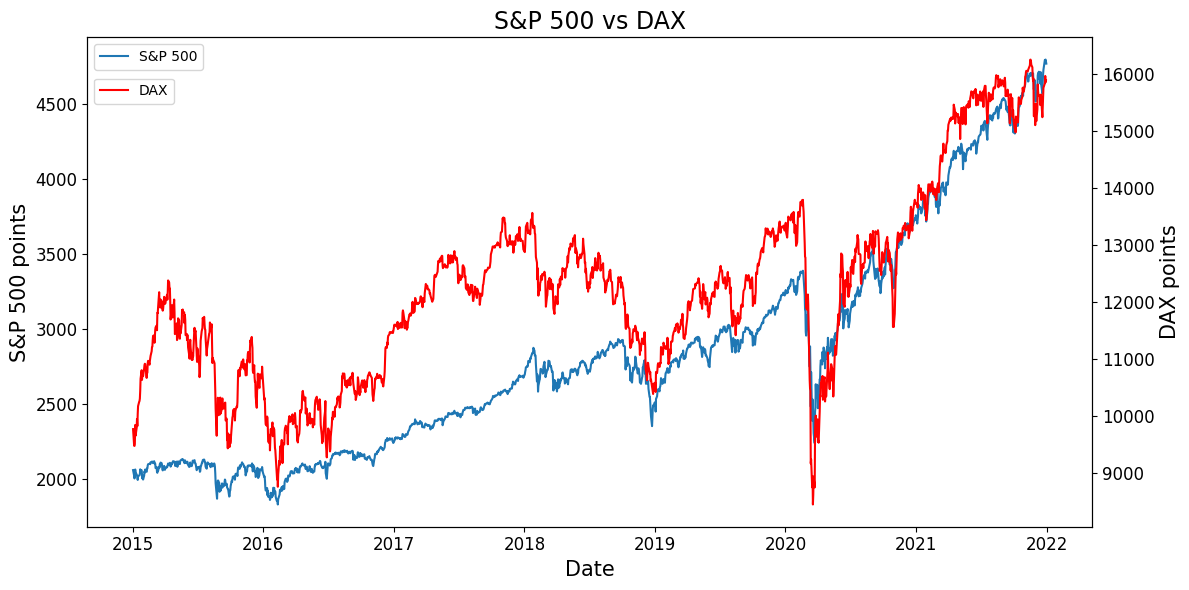

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot S&P 500
sns.lineplot(x='Date', y='Price', data=sp500_plot, ax=ax1, label='S&P 500')

# Create second y-axis and plot DAX
ax2 = ax1.twinx()
sns.lineplot(x='Date', y='Price', data=dax_plot, ax=ax2, color='red', label='DAX')

# Label axes
ax1.set_ylabel('S&P 500 points', fontsize=15)
ax2.set_ylabel('DAX points', fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

# Set title
ax1.set_title('S&P 500 vs DAX', fontsize=17)

# Position legends outside plot
ax1.legend(bbox_to_anchor=(0.0, 0.92), loc='lower left')
ax2.legend(bbox_to_anchor=(0.0, 0.85), loc='lower left')

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.show()

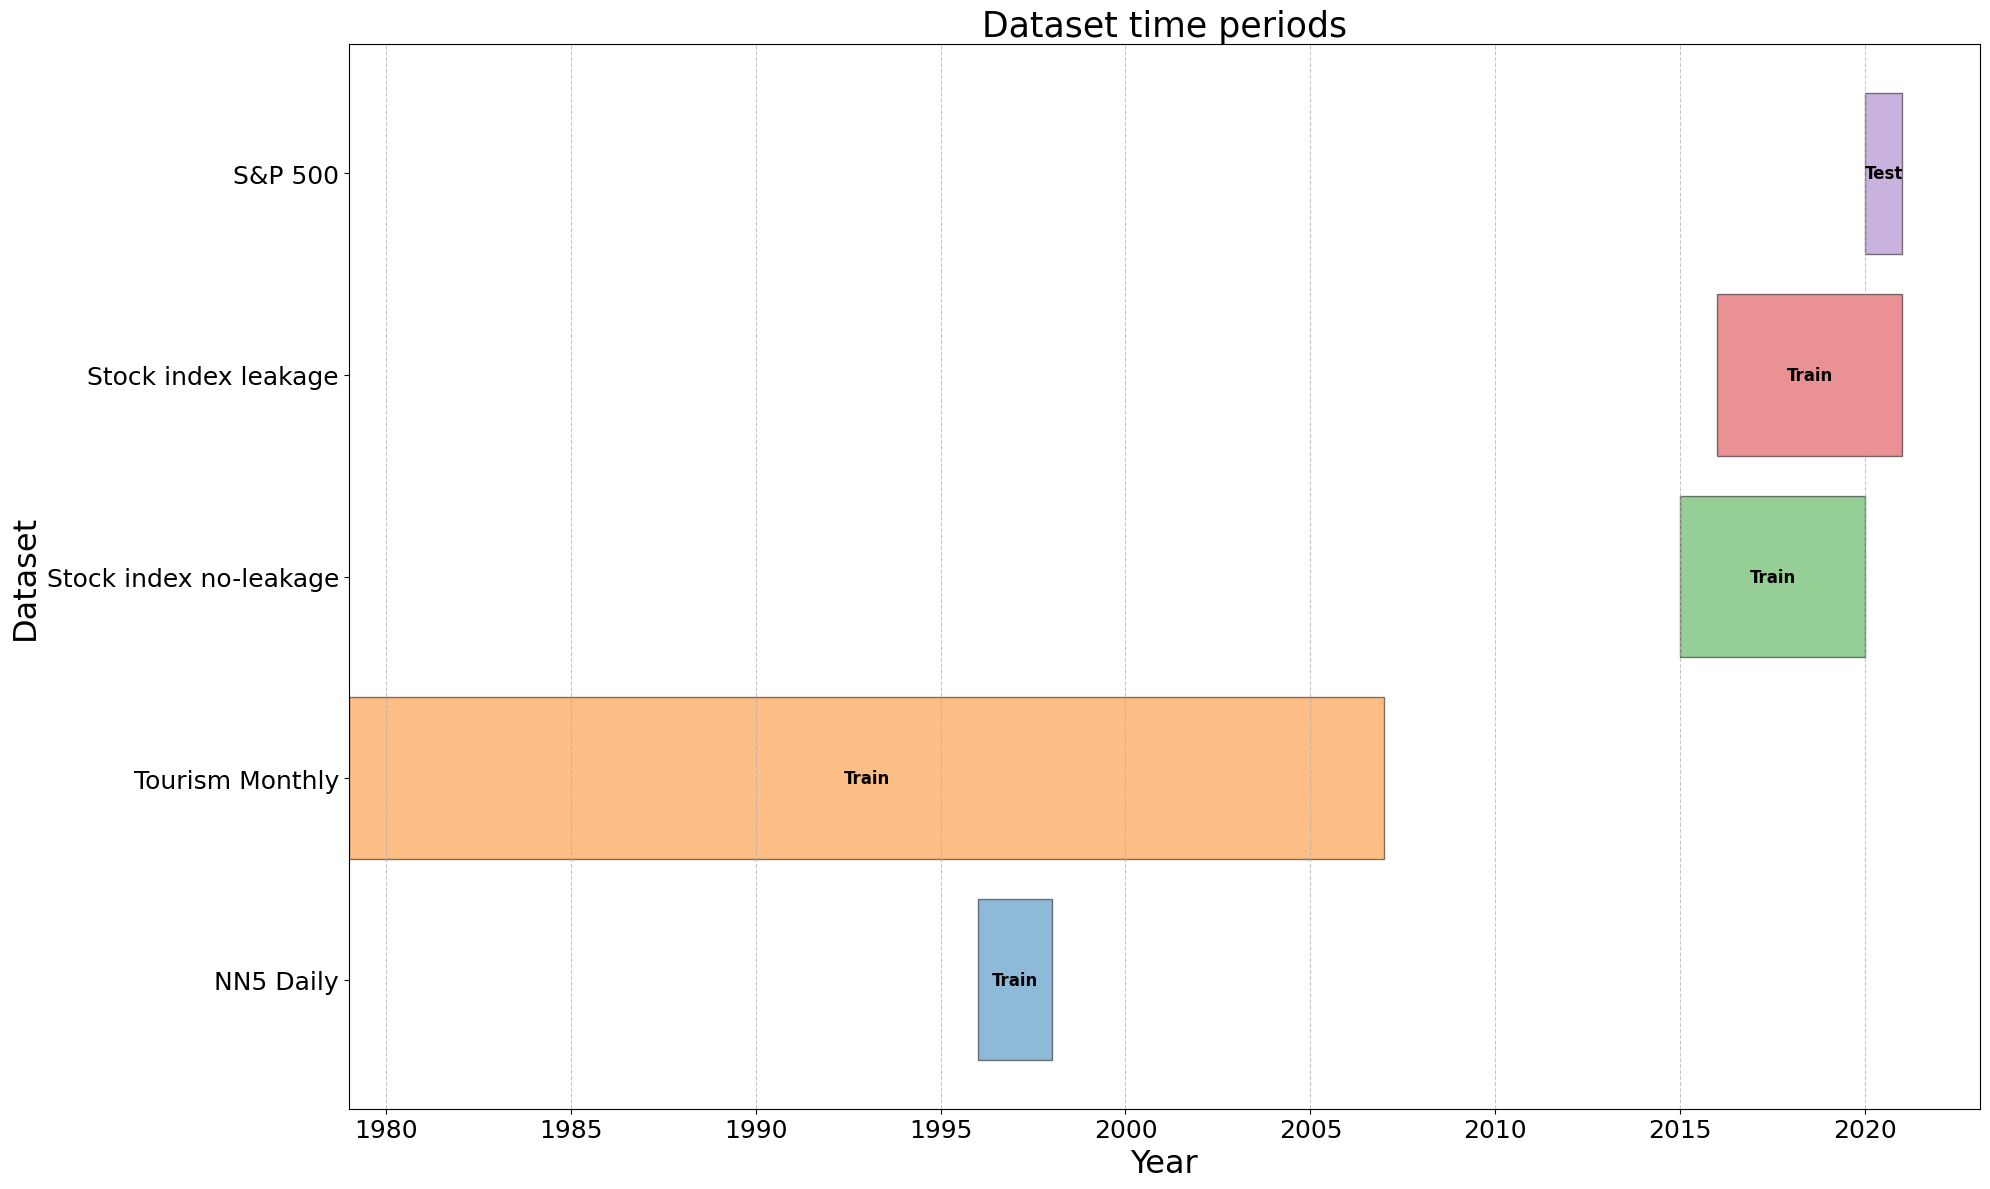

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
data = {
    'Dataset': ['NN5 Daily', 'Tourism Monthly', 'Stock index no-leakage', "Stock index leakage", "S&P 500"],
    "Domain": ["Train", "Train", "Train", "Train", "Test"],
    'Start_Year': [1996, 1979, 2015, 2016, 2020],
    'End_Year': [1998, 2007, 2020, 2021, 2021],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plot settings
plt.figure(figsize=(20, 12))

# Loop through the dataset and plot each bar
for i, row in df.iterrows():
    plt.barh(
        row['Dataset'],  # Dataset on y-axis
        row['End_Year'] - row['Start_Year'],  # Duration as width
        left=row['Start_Year'], 
        color=f'C{i}', 
        alpha=0.5, 
        edgecolor='black'
    )
    # Add domain name inside the bar
    plt.text(
        x=row['Start_Year'] + (row['End_Year'] - row['Start_Year']) / 2,  # Centered in the bar
        y=row['Dataset'],  
        s=row['Domain'],  # Display domain name
        va='center', 
        ha='center',
        fontsize=12, 
        color='black', 
        fontweight='bold'
    )

plt.xlabel('Year', fontsize=23)
plt.ylabel('Dataset', fontsize=23)
plt.title('Dataset time periods', fontsize=25)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=18)
plt.tight_layout()
plt.show()